In [1]:
import pandas as pd
import copy
import time
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import odeint

import kinetic_cell as vkc
import reactions as rxn
import options
import utils
import optimization

from autograd import grad
import autograd.numpy as adnp
import autograd.scipy as adsp
from autograd.builtins import tuple

import autograd_ivp as adivp

np.set_printoptions(precision=2)

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
# Example from neural ODEs page

niters = 2000
data_size = 1000
test_freq = 20
viz = True

true_A = np.array([[-0.1, 2.0], [-2.0, -0.1]])

def func(t,y,A):
    yp = np.dot(np.power(y,3), A)
    return yp

y0 = np.array([2., 0.])
t = np.linspace(0., 25., data_size)


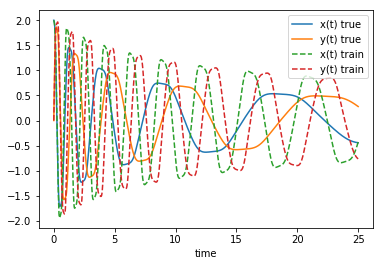

In [5]:
A_true = np.array([[-0.1, 2.0], [-2.0, -0.1]])
true_y = odeint(func, y0, t, args=(A_true,), tfirst = True)

A = A_true + 5e-1*(np.random.rand(2,2)-0.5)
y_perturb = odeint(func, y0, t, args=(A,), tfirst = True)

plt.plot(t, true_y[:,0])
plt.plot(t, true_y[:,1])

plt.plot(t, y_perturb[:,0], '--')
plt.plot(t, y_perturb[:,1], '--')
plt.legend(['x(t) true', 'y(t) true', 'x(t) train', 'y(t) train'])
plt.xlabel('time')
plt.show()

In [9]:
niters = 50
step_size = 1e-4

def loss(x):
    A = np.reshape(x,(2,2))
    y = odeint(func, y0, t, tuple((A,)))
    out = np.mean(np.power(y - true_y,2))
    print(out)
    return out

def loss_grad(x):
    A = np.reshape(x,(2,2))
    
    def lossAD(A):
        def func_temp(y,t,A):
            yp = adnp.dot(adnp.power(y,3), A)
            return yp
        y = odeintAD(func_temp, y0, t, tuple((A,)))
        out = adnp.mean(adnp.power(y - true_y,2))

        return out 

    _loss_grad = grad(lossAD)
    A_grad = _loss_grad(adnp.array(A))
    
    x_grad = np.reshape(A_grad,-1)
    return x_grad
    

A0 = A_true + 5e-1*(np.random.rand(2,2)-0.5)
x0 = np.reshape(A0,-1)

result = minimize(loss, x0, jac=loss_grad)
print(np.reshape(result.x,(2,2)))
    


RuntimeError: The array return by func must be one-dimensional, but got ndim=2.

In [ ]:
A_true = np.array([[-0.1, 2.0], [-2.0, -0.1]])
true_y = odeint(func, y0, t, args=(A_true,),tfirst = True)

A = A_true + 1e-1*np.random.rand(2,2)
y_perturb = odeint(func, y0, t, args=(A,),tfirst = True)

plt.plot(t, true_y[:,0])
plt.plot(t, true_y[:,1])

plt.plot(t, y_perturb[:,0], '--')
plt.plot(t, y_perturb[:,1], '--')
plt.legend(['x(t) true', 'y(t) true', 'x(t) train', 'y(t) train'])
plt.xlabel('time')
plt.show()

# Autodiff Kinetic Cell Experiments

1.0 OIL-H + 10.0 O2 -> 10.0 OIL
1.0 OIL + 5.0 O2 -> 5.484 CO2 + 0.0 H2O + 1.097 CO
Running heating rate 1: 2.0 C/min
Running heating rate 2: 8.0 C/min


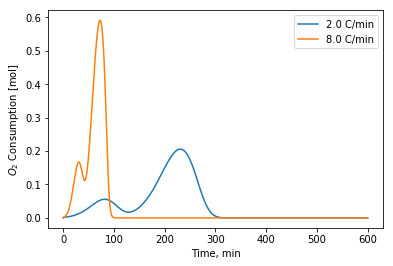

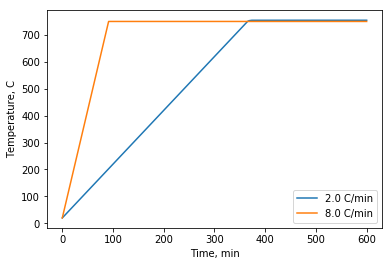

In [48]:
# Simulate without autodiff
opts = options.KineticCellOptions(reaction_type='Chen2')
# opts.rate_heat = [2, 8, 15, 30]
opts.rate_heat = [2, 8]
opts.max_temp = 750
opts.autodiff_enable = True

kc = vkc.KineticCell(opts = opts)
kc.reaction.print_reaction()
kc.run_RTO_exps(make_plot = True)
